In [1]:
import numpy as np
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load preprocessed data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [3]:
# Define pipelines for each model
pipelines = {
    'logistic': Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegression(max_iter=10000))
    ]),
    'random_forest': Pipeline([
        ('scaler', StandardScaler()),
        ('random_forest', RandomForestClassifier())
    ]),
    'gradient_boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('gradient_boosting', GradientBoostingClassifier())
    ])
}

In [4]:
# Define narrowed hyperparameters for GridSearch
param_grids = {
    'logistic': {
        'logistic__C': [0.1, 1, 10],
        'logistic__penalty': ['l2'],
        'logistic__solver': ['lbfgs']
    },
    'random_forest': {
        'random_forest__n_estimators': [50, 100],
        'random_forest__max_depth': [10, 20],
        'random_forest__min_samples_split': [5, 10]
    },
    'gradient_boosting': {
        'gradient_boosting__n_estimators': [50, 100],
        'gradient_boosting__learning_rate': [0.1, 0.2],
        'gradient_boosting__max_depth': [3, 5]
    }
}

In [5]:
def evaluate_model(grid_search, y_test, y_pred, y_pred_proba, model_name):
    # Best parameters
    print(f"\nBest Parameters for {model_name}:")
    print(grid_search.best_params_)

    # Classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    print(f"\nConfusion Matrix for {model_name}:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    # ROC-AUC score and ROC curve
    print(f"\nROC-AUC Score for {model_name}:")
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(roc_auc)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    # Save the best model
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, f'{model_name}_model_advanced.joblib')

Training and evaluating logistic model...

Best Parameters for logistic:
{'logistic__C': 10, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}

Classification Report for logistic:
              precision    recall  f1-score   support

         0.0       0.71      0.77      0.73      6988
         1.0       0.75      0.68      0.71      7012

    accuracy                           0.72     14000
   macro avg       0.73      0.72      0.72     14000
weighted avg       0.73      0.72      0.72     14000


Confusion Matrix for logistic:


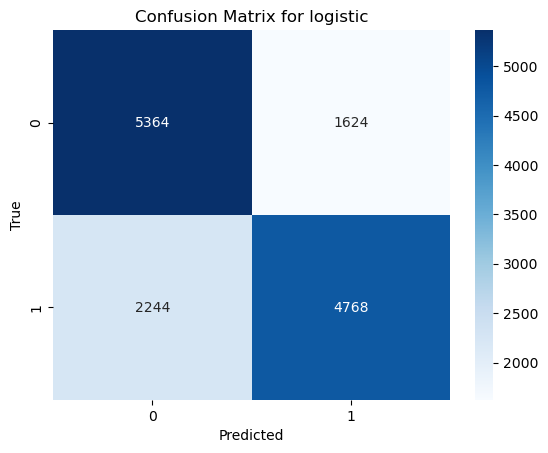


ROC-AUC Score for logistic:
0.7860753407112053


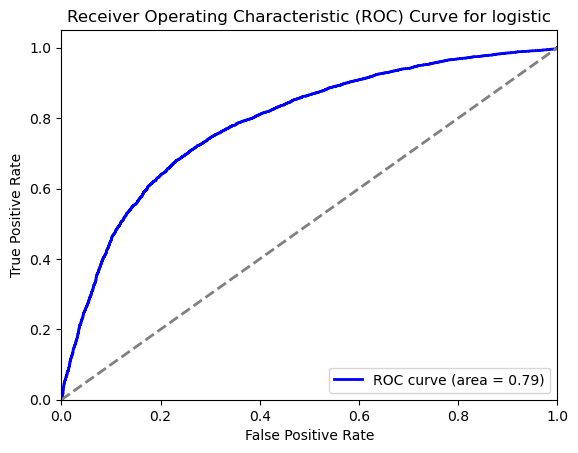

Training and evaluating random_forest model...

Best Parameters for random_forest:
{'random_forest__max_depth': 10, 'random_forest__min_samples_split': 5, 'random_forest__n_estimators': 100}

Classification Report for random_forest:
              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75      6988
         1.0       0.77      0.68      0.72      7012

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000


Confusion Matrix for random_forest:


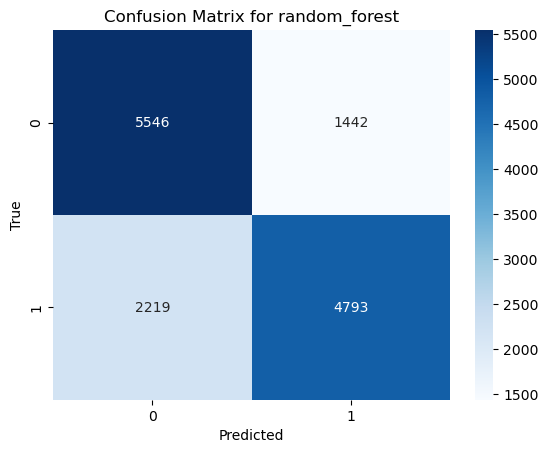


ROC-AUC Score for random_forest:
0.8020946735027141


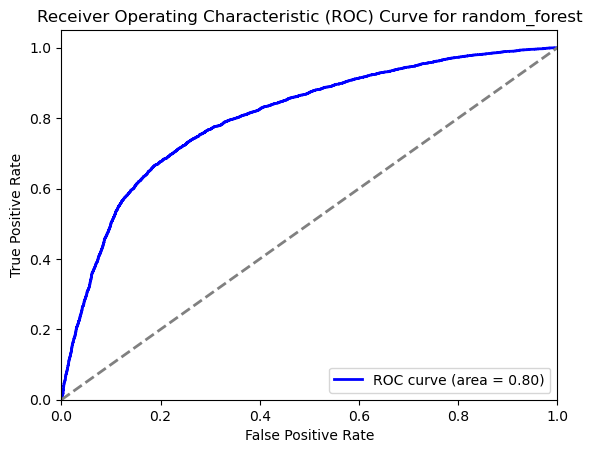

Training and evaluating gradient_boosting model...

Best Parameters for gradient_boosting:
{'gradient_boosting__learning_rate': 0.1, 'gradient_boosting__max_depth': 3, 'gradient_boosting__n_estimators': 100}

Classification Report for gradient_boosting:
              precision    recall  f1-score   support

         0.0       0.72      0.76      0.74      6988
         1.0       0.75      0.71      0.73      7012

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000


Confusion Matrix for gradient_boosting:


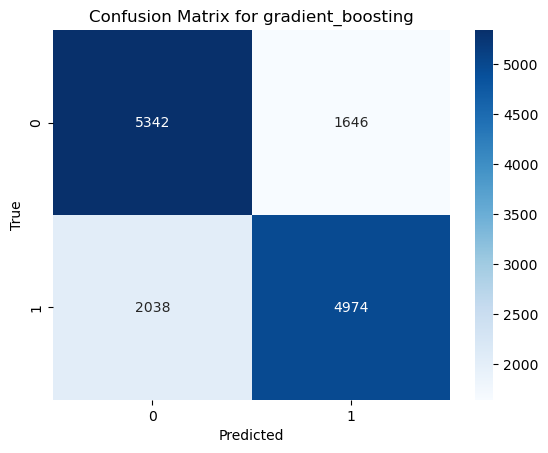


ROC-AUC Score for gradient_boosting:
0.8033615037562559


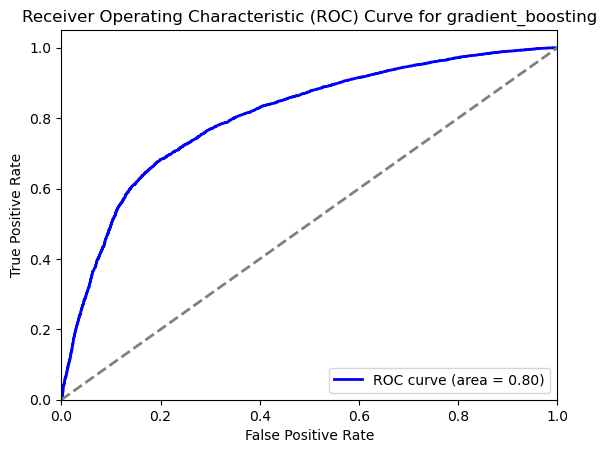

In [6]:
# Train and evaluate each model
for model_name, pipeline in pipelines.items():
    print(f"Training and evaluating {model_name} model...")

    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=3, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Predict and evaluate
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    evaluate_model(grid_search, y_test, y_pred, y_pred_proba, model_name)